# Лабораторная работа №6. Анализ и прогнозирование временного ряда.
## Задание
1. Выберите набор данных (датасет) для решения задачи прогнозирования временного ряда.
2. Визуализируйте временной ряд и его основные характеристики.
3. Разделите временной ряд на обучающую и тестовую выборку.
4. Произведите прогнозирование временного ряда с использованием как минимум двух методов.
5. Визуализируйте тестовую выборку и каждый из прогнозов.
6. Оцените качество прогноза в каждом случае с помощью метрик.

## Импорт библиотек

In [30]:
import numpy as np
import pandas as pd
from pandas import Series
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates

## Загрузка датасета
В качестве датасета взяты данные о средней температуре по дням: https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities?resource=download

Сделана выборка по городу Москве и проведено преобразование температуры из шкалы Фаренгейта в шкалу Цельсия и удалены выбросы.

In [31]:
data = pd.read_excel('moscow_temperature.xlsx', parse_dates=True, header=0, index_col=0)
data.head()

,AvgTemperature
Date,
1995-01-01,0.166667
1995-01-02,-0.166667
1995-01-03,-2.888889
1995-01-04,-8.944444
1995-01-05,-4.555556


In [32]:
data.dtypes

AvgTemperature    float64
dtype: object

In [33]:
data.shape

(9235, 1)

## Визуализация временного ряда

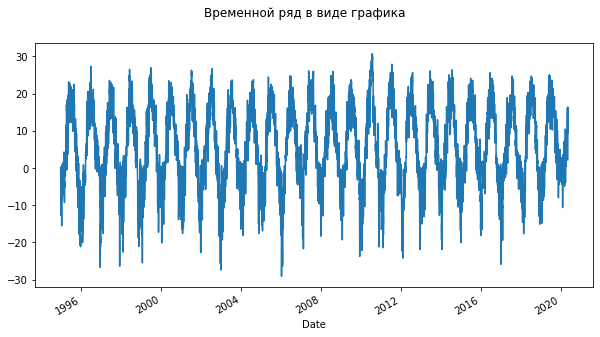

In [34]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
data.plot(ax=ax, legend=False)
pyplot.show()

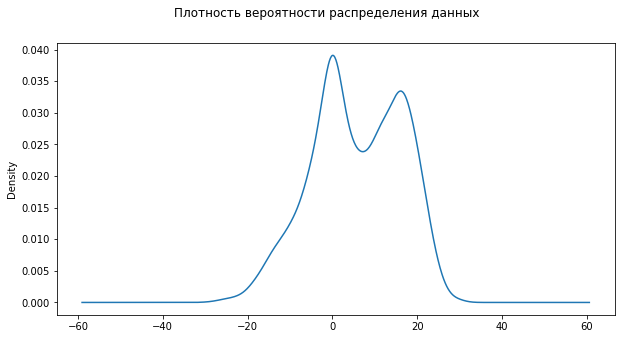

In [35]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Плотность вероятности распределения данных')
data.plot(ax=ax, kind='kde', legend=False)
pyplot.show()

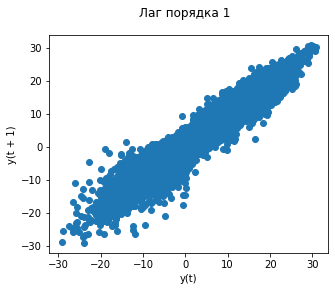

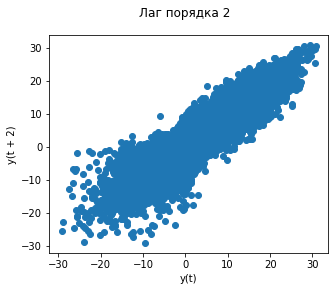

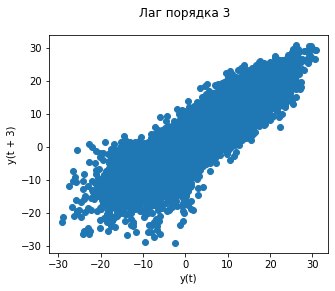

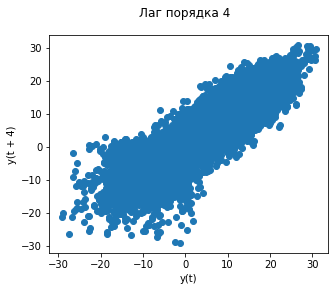

In [36]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(data, lag=i, ax=ax)
    pyplot.show()

Можно сделать вывод о положительной автокорреляциии временного ряда

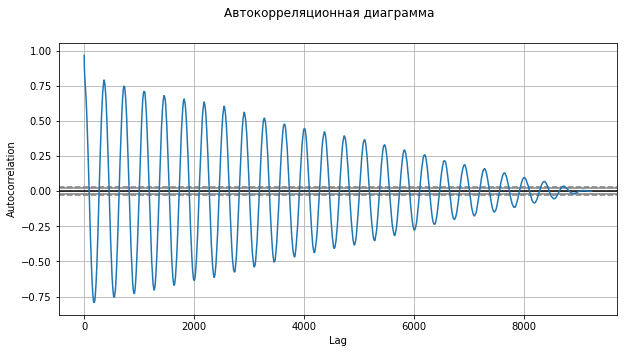

In [37]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(data, ax=ax)
pyplot.show()

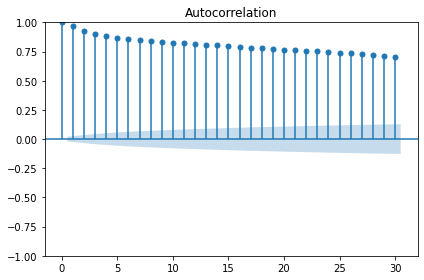

In [38]:
# Авторкорреляционная функция
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data, lags=30)
plt.tight_layout()

c:\Users\Zid\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


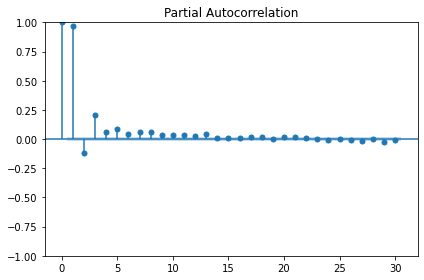

In [39]:
# Частичная автокорреляционая функция
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data, lags=30)
plt.tight_layout()

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Аддитивная модель
def plot_decompose(data=data['AvgTemperature'], model='add', period=365):
    result_add = seasonal_decompose(data, model = model, period=period)
    fig = result_add.plot()
    fig.set_size_inches((10, 8))
    # Перерисовка
    fig.tight_layout()
    plt.show()

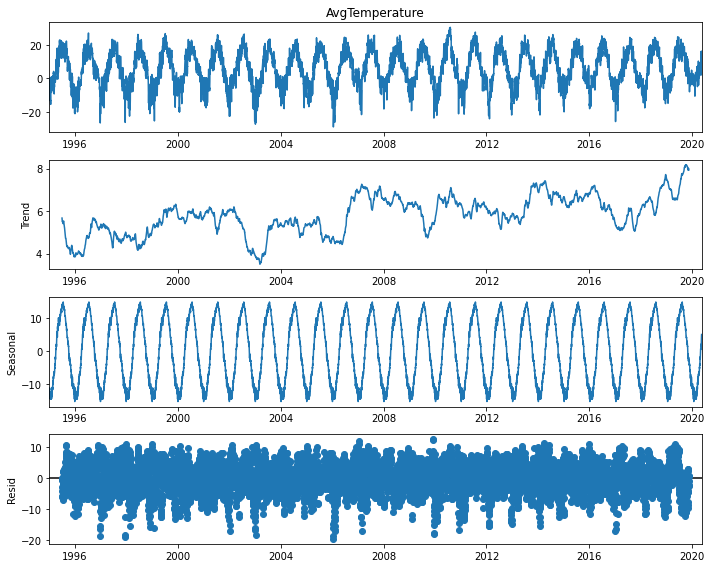

In [41]:
plot_decompose(data=data['AvgTemperature'], model='add')

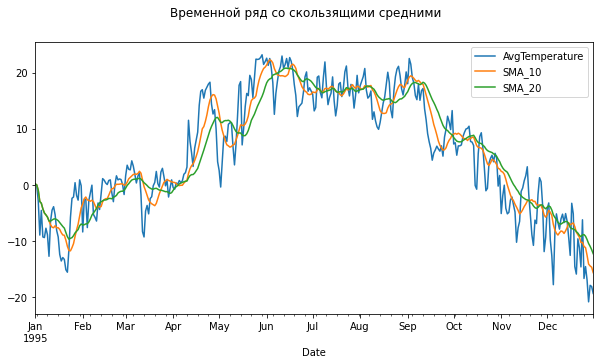

In [42]:
# Скользящая средняя
data2 = data.copy()
# Простое скользящее среднее (SMA)
data2['SMA_10'] = data2['AvgTemperature'].rolling(10, min_periods=1).mean()
data2['SMA_20'] = data2['AvgTemperature'].rolling(20, min_periods=1).mean()

fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд со скользящими средними')
data2[:365].plot(ax=ax, legend=True)
pyplot.show()


## Прогнозирование временного ряда

In [43]:
from sklearn.metrics import mean_squared_error, median_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Целочисленная метка шкалы времени 
xnum = list(range(data.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = data['AvgTemperature'].values[0:365]
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

# Параметры модели (p,d,q) 
arima_order = (6,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

# Формирование предсказаний
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])
# Вычисление метрики RMSE
error_es = mean_squared_error(test, predictions_es, squared=False)

In [44]:
# Ошибка прогноза
np.mean(Y), error_arima, error_es

(5.672450532724507, 3.4519665935390247, 3.4972908847917425)

In [45]:
np.median(Y), median_absolute_error(test, predictions_arima), median_absolute_error(test, predictions_es)

(5.555555555555555, 2.0622052876819623, 1.8611110305041783)

In [47]:
# Записываем предсказания в DataFrame
data2.loc[0:365, 'predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
data2.loc[0:365,'predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)

C:\Users\Zid\AppData\Local\Temp\ipykernel_2100\3221741434.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data2.loc[0:365, 'predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
C:\Users\Zid\AppData\Local\Temp\ipykernel_2100\3221741434.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data2.loc[0:365,'predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)


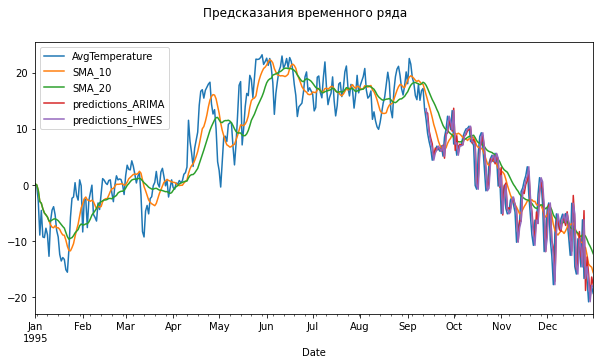

In [48]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
data2[0:365].plot(ax=ax, legend=True)
pyplot.show()

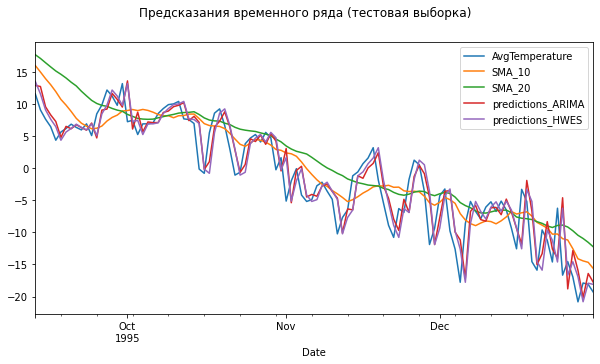

In [49]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data2[train_size:365].plot(ax=ax, legend=True)
pyplot.show()

## Прогнозирование временного ряда методом символьной регресии

In [50]:
from gplearn.genetic import SymbolicRegressor

function_set = ['add', 'sub', 'mul', 'div', 'sin']
est_gp = SymbolicRegressor(population_size=500, metric='mse',
                               generations=70, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

est_gp.fit(np.array(xnum_train).reshape(-1, 1), train.reshape(-1, 1))

c:\Users\Zid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1095: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   263.65      7.25395e+55      766          161.255              N/A      1.72m
   1   145.19      3.09809e+11       44          152.856              N/A     39.58s
   2   171.81      4.17981e+09        1          112.301              N/A     45.37s
   3   110.12      9.11173e+26       81          36.5714              N/A     35.28s
   4    44.45      2.30657e+07       81          36.0829              N/A     22.72s
   5    62.03      2.03246e+08       59          32.7652              N/A     25.41s
   6    82.82           720322       87          31.6176              N/A     27.35s
   7    87.11           983533       83          30.7757              N/A     27.71s
   8    82.05      1.20359e+06       85          28.6753              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin'],
                  generations=70, init_depth=(4, 10), metric='mse',
                  population_size=500, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [51]:
print(est_gp._program)

add(div(sub(sin(sin(div(X0, X0))), sub(add(-28.667, X0), div(X0, X0))), sub(add(sub(sub(sub(sub(sub(sub(div(X0, 83.927), sin(div(sub(sin(X0), sub(add(sub(sub(X0, -59.385), X0), X0), mul(X0, -97.427))), sub(X0, -59.385)))), sin(div(sub(sin(sub(add(-28.667, X0), mul(X0, -97.427))), -97.427), sub(sub(sub(X0, -59.385), X0), sub(sub(X0, -59.385), add(-9.223, 56.371)))))), sin(div(sub(sin(sub(X0, X0)), sub(add(div(X0, X0), X0), mul(X0, -97.427))), sub(add(sub(-9.223, sub(X0, -59.385)), sub(add(sub(X0, -59.385), mul(-62.536, 42.041)), sub(sub(X0, -59.385), add(-9.223, 56.371)))), sub(sub(X0, -59.385), add(-9.223, 56.371)))))), sin(div(sub(sin(sub(sin(sub(X0, X0)), sub(add(-28.667, X0), mul(X0, -97.427)))), sub(add(-28.667, X0), mul(X0, -97.427))), sub(add(sub(add(div(X0, X0), div(-9.331, X0)), sub(X0, -59.385)), sub(add(sub(X0, X0), mul(-62.536, 42.041)), sub(sub(X0, -59.385), add(-9.223, 56.371)))), sub(sub(X0, -59.385), add(add(div(X0, X0), div(-9.331, X0)), 56.371)))))), sin(div(mul(X0, -9

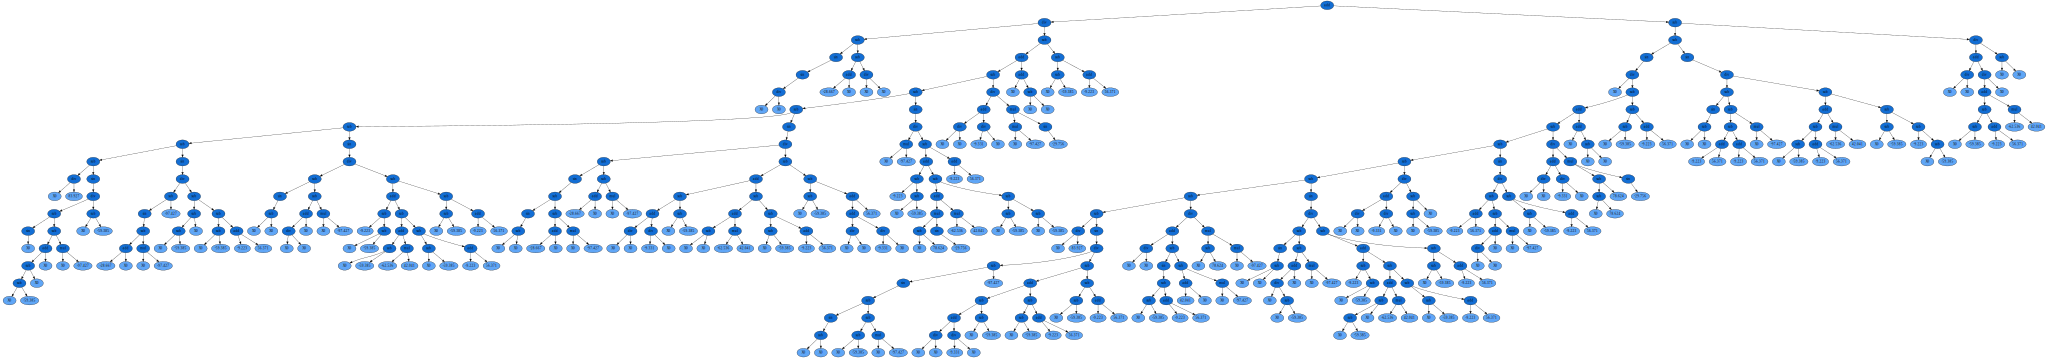

In [52]:
import graphviz
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [53]:
# Предсказания
y_gp = est_gp.predict(np.array(xnum_test).reshape(-1, 1))
y_gp[:10]

array([16.88189392, 16.86562467, 16.89399438, 16.89989473, 16.90536876,
       16.96368204, 17.00870913, 17.06504184, 17.17730579, 17.28447638])

In [54]:
# Записываем предсказания в DataFrame
data2['predictions_GPLEARN'] = (train_size * [np.NAN]) + list(y_gp)

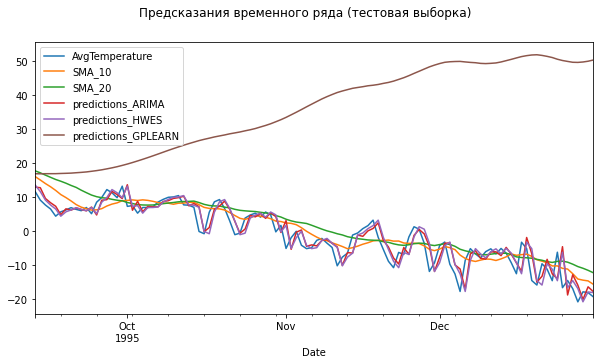

In [55]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data2[train_size:365].plot(ax=ax, legend=True)
pyplot.show()